# Exploratory Data Analysis
Group 20

This notebook explores the dataset statistically and graphically. 
 
1. Quantity and distribution of missing values in dataset
2. Correlation of features
3. Distribution of features
4. Order of feature importance of given features




In [3]:
# Data Handling and Analysis Libraries

import pandas as pd
import numpy as np

# Data Visualisation Libraries

import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Modelling Libraries

from scipy.stats import probplot, chisquare
from lightgbm import LGBMClassifier

# Feature Selection Library

from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2


In [4]:
# Load Original Data

train_x = pd.read_csv(r"train_x.csv")
train_y = pd.read_csv(r"train_y.csv")

# Load Imputed Data

train_impt = pd.read_csv(r"forestImputedTrain.csv")

# Sub and Super Datasets

train_xy = train_x.copy()
train_xy['label'] = train_y['Label']

train_impt_dscrt = train_impt.copy()
train_impt_dscrt = train_impt_dscrt.drop(['ID', 'Expense','Income','Score1','Score2','Score3','Score4','Score5'], axis=1)
 
train_impt_conts = train_impt.drop(['ID','Loan type','Occupation type','Age','Label'],axis=1)

In [5]:
# Encoding all the alphabetic variable in train_xy to numeric values for aid visualization

for i in range(len(train_xy)):
    cell = train_xy['Loan type'].iloc[i]
    if cell == 'A':
        train_xy['Loan type'].iloc[i] = 0
    elif cell == 'B':
        train_xy['Loan type'].iloc[i] = 1
        
for i in range(len(train_xy)):
    cell = train_xy['Occupation type'].iloc[i]
    if cell == 'X':
        train_xy['Occupation type'].iloc[i] = 0
    elif cell == 'Y':
        train_xy['Occupation type'].iloc[i] = 1
    elif cell == 'Z':
        train_xy['Occupation type'].iloc[i] = 2

D:\anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Function Definitions
In this section, we have defined some functions that are commonly used in exploratory data analysis (EDA). 
Functions are:

   1. missing_table: Tally of missing values in the dataset by column, arranged in descending order.
   2. nunique_table: Tally of number of unique values in every column. Helps determine whether column has continuous data or is categorical.
   3. dist_dashboard: Displays histogram and box plots one by one for each numeric column in data   
   4. percentage:Gives the percentage of null values present in each feature
   5. scatter:Gives scatter plot for given features
   6. lgbm_importance: Displays bar plot of feature importances by fitting LightGBM model over it




In [36]:
def missing_table(df, threshold=None, ascending=False):
    """
    Counts number of missing values and percentage of missing values in every column
    of input pandas DataFrame object.
    
    :params: 
        threshold: (int/float) returns only those columns with number/percentage of missing
                   values higher than this value, default is None (returns all columns)
        ascending: (boolean) sorts table in ascending order of missing values
                   if set to True, default is False
                   
    :return: columns with missing values above threshold; pandas DataFrame object with column 
             name, number of missing values and percentage of missing values
    """
    cols = df.columns
    miss_vals = np.array([df[col].isnull().sum() for col in cols])
    miss_vals_percent = (miss_vals.astype('float')/len(df))*100
    
    miss_table = pd.DataFrame(np.vstack((cols, miss_vals, miss_vals_percent)).T,
                              columns=['column', 'missing values', '% missing values'])
    
    if threshold is None:
        miss_table = miss_table.sort_values(by='missing values', ascending=ascending)
        return miss_table
    else:
        if threshold <= 1.0:
            ret = miss_table.loc[miss_table['% missing values'] >= threshold*100.0, :]
            return ret.sort_values(by='missing values', ascending=ascending)
        elif threshold > 1.0:
            ret = miss_table.loc[miss_table['missing values'] >= threshold, :]
            return ret.sort_values(by='missing values', ascending=ascending)
        else:
            raise ValueError('Invalid threshold type')


def nunique_table(df, which=None, ascending=False):
    """
    Counts number of unique values for specified/all columns of the pandas DataFrame. Columns
    with few unique values could potentially be represented as categorical variables.
    
    :params:
        which:      (list) function returns unique value counts only for columns 
                    specified in this list. Default (None) returns counts for all columns
        ascending:  (boolean) sorts table in ascending order of missing values
                    if set to True, default is False 
                    
    :return: pandas DataFrame object column name, number of unique values and percentage of 
             total values which are unique
    """
    cols = df.columns
    unique_vals = np.array([df[col].nunique() for col in cols])
    percentage = (unique_vals.astype('float')/len(df))*100
    
    unique_table = pd.DataFrame(np.vstack((cols, unique_vals, percentage)).T,
                                columns=['column', 'unique values', '% of total'])
    unique_table = unique_table.sort_values(by='unique values', ascending=ascending)
    
    if which is None:
        return unique_table
    else:
        part_cols = np.array(which)
        unique_vals = df[which].nunique().values
        percentage = (unique_vals/len(df))*100
        
        unique_table = pd.DataFrame(np.vstack((part_cols, unique_vals, percentage)).T,
                             columns=['column', 'unique values', '% of total'])
        unique_table['unique values'] = unique_table['unique values'].astype('int')
        unique_table['% of total'] = unique_table['% of total'].astype('float')
        unique_table = unique_table.sort_values(by='unique values', ascending=ascending)
        return unique_table


def dist_dashboard(df, num_cols=None, transform=None):

    if num_cols is None:
        raise ValueError('Numeric columns not specified')
    else:
        if transform is not None:
            df[num_cols] = df[num_cols].apply(transform)
        for col in num_cols:
            plt.figure(figsize=(13,5))

            # Histogram Plot
            plt.hist(df[col], bins=20, edgecolor='black')
            plt.grid()
            plt.title(col)
            plt.ylabel('frequency')

            # Box Plot
            df.boxplot(figsize=(13,5),column=col,by="Label" )
            plt.suptitle(" ")
            plt.grid()
            plt.tight_layout()
            plt.show()




def percentage(df, num_cols):
    for cols in num_cols:
        if (cols!='Label'):
            print(pd.crosstab(df[cols],df["Label"]))
            loantype = pd.crosstab(df["Loan type"],df["Label"])
            loantype.div(loantype.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
            plt.xlabel(cols)
            plt.ylabel("Percentage")
            plt.show()

        
def scatter(df, df1, num_cols=None):
    df1=df.drop(['Label'], axis=1)
    if num_cols is None:
        raise ValueError('Numeric columns not specified')
    else:
        for col1 in num_cols:
            for col2 in num_cols:
                if (col2>col1):
                    plt.figure(figsize=(10,10))
                    plt.title(col1+'&'+col2)
                    plt.xlabel(col1)
                    plt.ylabel(col2)
                    sns.scatterplot(df1[col1],df1[col2], hue=df['Label'])
                    plt.show()
                    

def lgbm_importance(df, uid=None, target=None, scale_pos_weight=1, ascending=True):
    
    cols = df.drop([uid, target], axis=1).columns.tolist()
    y = df[target].values
    X = df.drop([uid, target], axis=1).values
    
    model = LGBMClassifier(n_estimators=200,
                           learning_rate=0.05,
                           
                           objective='binary',
                           scale_pos_weight=scale_pos_weight,
                           random_state=123)
    model.fit(X, y)
    f_imps = model.feature_importances_
    
    # Plot importances
    table = pd.DataFrame({'Column': cols, 'Importance': f_imps})
    table = table.sort_values(by='Importance', ascending=ascending)
    table = table.set_index(table['Column'])
    
    plt.figure(figsize=(10,10))
    table['Importance'].plot.barh()
    plt.title('Feature Importance')
    plt.grid()
    plt.show()

                    


# Understanding the Data

Here we will get to know about the data more like :
1. types of data present
2. description of data
3. unique values present 
4. catagorical features


In [7]:
train_x

ID      Expense       Income Loan type Occupation type  Age  \
0          1  1830.943788  14767.28013         B               Y  1.0   
1          2  1645.302546  15272.26775         B               Y  0.0   
2          3  1555.026392  17482.49734         A               Y  0.0   
3          4          NaN  16257.66493         A               Y  0.0   
4          5  1777.648916  16316.29914         B               X  1.0   
...      ...          ...          ...       ...             ...  ...   
79995  79996  1470.317116  16659.49663         A             NaN  0.0   
79996  79997  1923.617480  14910.36890         B               Y  0.0   
79997  79998  1711.147154  15962.25945         A               Y  1.0   
79998  79999  1673.822523  15525.27413         B               Z  0.0   
79999  80000  1486.290579  16207.20250         A               Z  0.0   

         Score1      Score2     Score3      Score4       Score5  
0      0.016885  205.196182  22.521523  600.911200  3464.613291  
1      0.240375  194.266317   5.349117  600.888816  3374.921455  
2      0.213921  183.529871  -1.054954  598.596944  3331.304886  
3      0.303909  191.228965   6.971750  602.447203  3392.275849  
4           NaN  224.074728  11.218489  605.947340  3438.864083  
...         ...         ...        ...         ...          ...  
79995  0.208757  172.526308  -5.332184  596.648261  3290.377932  
79996  0.201837  186.252458  15.425841  600.855069  3509.388221  
79997  0.226396  196.098150   8.161353  601.360722  3406.734018  
79998  0.101090  186.390184   3.381393  596.750750  3388.700770  
79999  0.187832  182.131337        NaN  597.251640          NaN  

[80000 rows x 11 columns]

In [8]:
print('Shape of the dataset is: ') 
train_x.shape

Shape of the dataset is: 


(80000, 11)

In [9]:
train_x.describe()

ID       Expense        Income           Age        Score1  \
count  80000.000000  77956.000000  78045.000000  77986.000000  78060.000000   
mean   40000.500000   1733.993769  15641.112448      0.441105      0.187617   
std    23094.155105    133.239147   1065.620737      0.496522      0.123509   
min        1.000000   1126.809192  11171.703240      0.000000     -0.563328   
25%    20000.750000   1644.263974  14925.658150      0.000000      0.112651   
50%    40000.500000   1736.276720  15624.259290      0.000000      0.189877   
75%    60000.250000   1824.376793  16346.084990      1.000000      0.265243   
max    80000.000000   2309.129903  20728.915330      1.000000      0.705737   

             Score2        Score3        Score4        Score5  
count  77964.000000  78045.000000  78028.000000  78002.000000  
mean     192.065584      9.365450    600.397742   3417.740403  
std       28.558250      8.760134      3.826112     64.391844  
min       40.572797    -28.885235    581.806404   3124.413430  
25%      173.415940      3.514901    597.894759   3374.406833  
50%      191.056193      8.883862    600.095436   3418.793524  
75%      209.727593     14.746607    602.597131   3461.384283  
max      338.073551     50.691479    619.623108   3692.731924

In [10]:
train_x.nunique()

ID                 80000
Expense            77953
Income             78038
Loan type              2
Occupation type        3
Age                    2
Score1             78054
Score2             77962
Score3             78045
Score4             78004
Score5             77987
dtype: int64

In [11]:
train_x.isnull().sum()

ID                    0
Expense            2044
Income             1955
Loan type          2011
Occupation type    1859
Age                2014
Score1             1940
Score2             2036
Score3             1955
Score4             1972
Score5             1998
dtype: int64

In [12]:
train_y

ID  Label
0          1    0.0
1          2    0.0
2          3    0.0
3          4    0.0
4          5    0.0
...      ...    ...
79995  79996    0.0
79996  79997    0.0
79997  79998    0.0
79998  79999    0.0
79999  80000    0.0

[80000 rows x 2 columns]

In [13]:
train_xy

ID      Expense       Income Loan type Occupation type  Age  \
0          1  1830.943788  14767.28013         1               1  1.0   
1          2  1645.302546  15272.26775         1               1  0.0   
2          3  1555.026392  17482.49734         0               1  0.0   
3          4          NaN  16257.66493         0               1  0.0   
4          5  1777.648916  16316.29914         1               0  1.0   
...      ...          ...          ...       ...             ...  ...   
79995  79996  1470.317116  16659.49663         0             NaN  0.0   
79996  79997  1923.617480  14910.36890         1               1  0.0   
79997  79998  1711.147154  15962.25945         0               1  1.0   
79998  79999  1673.822523  15525.27413         1               2  0.0   
79999  80000  1486.290579  16207.20250         0               2  0.0   

         Score1      Score2     Score3      Score4       Score5  label  
0      0.016885  205.196182  22.521523  600.911200  3464.613291    0.0  
1      0.240375  194.266317   5.349117  600.888816  3374.921455    0.0  
2      0.213921  183.529871  -1.054954  598.596944  3331.304886    0.0  
3      0.303909  191.228965   6.971750  602.447203  3392.275849    0.0  
4           NaN  224.074728  11.218489  605.947340  3438.864083    0.0  
...         ...         ...        ...         ...          ...    ...  
79995  0.208757  172.526308  -5.332184  596.648261  3290.377932    0.0  
79996  0.201837  186.252458  15.425841  600.855069  3509.388221    0.0  
79997  0.226396  196.098150   8.161353  601.360722  3406.734018    0.0  
79998  0.101090  186.390184   3.381393  596.750750  3388.700770    0.0  
79999  0.187832  182.131337        NaN  597.251640          NaN    0.0  

[80000 rows x 12 columns]

In [14]:
train_xy.dtypes

ID                   int64
Expense            float64
Income             float64
Loan type           object
Occupation type     object
Age                float64
Score1             float64
Score2             float64
Score3             float64
Score4             float64
Score5             float64
label              float64
dtype: object

In [15]:
train_impt

ID      Expense       Income  Loan type  Occupation type  Age  \
0          1.0  1830.943788  14767.28013        1.0              1.0  1.0   
1          2.0  1645.302546  15272.26775        1.0              1.0  0.0   
2          3.0  1555.026392  17482.49734        0.0              1.0  0.0   
3          4.0  1681.231479  16257.66493        0.0              1.0  0.0   
4          5.0  1777.648916  16316.29914        1.0              0.0  1.0   
...        ...          ...          ...        ...              ...  ...   
79995  79996.0  1470.317116  16659.49663        0.0              2.0  0.0   
79996  79997.0  1923.617480  14910.36890        1.0              1.0  0.0   
79997  79998.0  1711.147154  15962.25945        0.0              1.0  1.0   
79998  79999.0  1673.822523  15525.27413        1.0              2.0  0.0   
79999  80000.0  1486.290579  16207.20250        0.0              2.0  0.0   

         Score1      Score2     Score3      Score4       Score5  Label  
0      0.016885  205.196182  22.521523  600.911200  3464.613291    0.0  
1      0.240375  194.266317   5.349117  600.888816  3374.921455    0.0  
2      0.213921  183.529871  -1.054954  598.596944  3331.304886    0.0  
3      0.303909  191.228965   6.971750  602.447203  3392.275849    0.0  
4      0.298502  224.074728  11.218489  605.947340  3438.864083    0.0  
...         ...         ...        ...         ...          ...    ...  
79995  0.208757  172.526308  -5.332184  596.648261  3290.377932    0.0  
79996  0.201837  186.252458  15.425841  600.855069  3509.388221    0.0  
79997  0.226396  196.098150   8.161353  601.360722  3406.734018    0.0  
79998  0.101090  186.390184   3.381393  596.750750  3388.700770    0.0  
79999  0.187832  182.131337  -4.957009  597.251640  3298.088378    0.0  

[80000 rows x 12 columns]

In [16]:
train_impt.dtypes

ID                 float64
Expense            float64
Income             float64
Loan type          float64
Occupation type    float64
Age                float64
Score1             float64
Score2             float64
Score3             float64
Score4             float64
Score5             float64
Label              float64
dtype: object

In [17]:
train_impt_conts

Expense       Income    Score1      Score2     Score3      Score4  \
0      1830.943788  14767.28013  0.016885  205.196182  22.521523  600.911200   
1      1645.302546  15272.26775  0.240375  194.266317   5.349117  600.888816   
2      1555.026392  17482.49734  0.213921  183.529871  -1.054954  598.596944   
3      1681.231479  16257.66493  0.303909  191.228965   6.971750  602.447203   
4      1777.648916  16316.29914  0.298502  224.074728  11.218489  605.947340   
...            ...          ...       ...         ...        ...         ...   
79995  1470.317116  16659.49663  0.208757  172.526308  -5.332184  596.648261   
79996  1923.617480  14910.36890  0.201837  186.252458  15.425841  600.855069   
79997  1711.147154  15962.25945  0.226396  196.098150   8.161353  601.360722   
79998  1673.822523  15525.27413  0.101090  186.390184   3.381393  596.750750   
79999  1486.290579  16207.20250  0.187832  182.131337  -4.957009  597.251640   

            Score5  
0      3464.613291  
1      3374.921455  
2      3331.304886  
3      3392.275849  
4      3438.864083  
...            ...  
79995  3290.377932  
79996  3509.388221  
79997  3406.734018  
79998  3388.700770  
79999  3298.088378  

[80000 rows x 7 columns]

In [18]:
train_impt_conts.dtypes

Expense    float64
Income     float64
Score1     float64
Score2     float64
Score3     float64
Score4     float64
Score5     float64
dtype: object

In [19]:
train_impt_dscrt

Loan type  Occupation type  Age  Label
0            1.0              1.0  1.0    0.0
1            1.0              1.0  0.0    0.0
2            0.0              1.0  0.0    0.0
3            0.0              1.0  0.0    0.0
4            1.0              0.0  1.0    0.0
...          ...              ...  ...    ...
79995        0.0              2.0  0.0    0.0
79996        1.0              1.0  0.0    0.0
79997        0.0              1.0  1.0    0.0
79998        1.0              2.0  0.0    0.0
79999        0.0              2.0  0.0    0.0

[80000 rows x 4 columns]

In [20]:
train_impt_dscrt.dtypes

Loan type          float64
Occupation type    float64
Age                float64
Label              float64
dtype: object

# Missing Value Analysis


In this section, we quantify the amount of missing data in train.csv and attempt to find any patterns in the distribution of missing data in the table, using functions from seaborn library.


In [21]:
missing_table(train_xy, threshold=0.0)

column missing values % missing values
11            label           3903          4.87875
1           Expense           2044            2.555
7            Score2           2036            2.545
5               Age           2014           2.5175
3         Loan type           2011          2.51375
10           Score5           1998           2.4975
9            Score4           1972            2.465
2            Income           1955          2.44375
8            Score3           1955          2.44375
6            Score1           1940            2.425
4   Occupation type           1859          2.32375
0                ID              0                0

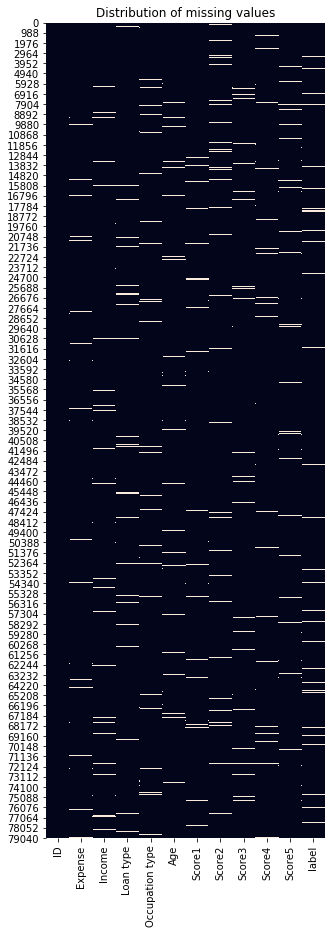

In [22]:
plt.figure(figsize=(5,15))
sns.heatmap(train_xy.isnull(), cbar=False)
plt.title('Distribution of missing values')
plt.show()

We can see that the missing values are distributed equally throughout the features and not concentrated to some area.

They can be filled by using appropriate imputation functions.

# Feature Distribution
In this section we will see the distributions of non-null data for each feature.We will analyze the features in the following aspects.

1. Class imbalance
2. Number of unique values to confirm continuous valued feature
3. Distribution of values and box plot for finding outliers
4. class proportion for each catagorical feature


In [23]:
#dropping rows with label as null values for analysis
train_xy=train_xy.drop(train_xy.index[train_xy[train_xy['label'].isnull()].index])

#Class imbalance
train_xy['label'] = train_xy.label.astype('int')
values_table = train_xy.label.value_counts()

# Imablance correction hyperarameter for LightGBM
scale_pos_weight = values_table.values.astype('float')[0]/values_table.values.astype('float')[1]

print(values_table)
print('')
print("scale_pos_weight: {:.4f}".format(scale_pos_weight))

0    71064
1     5033
Name: label, dtype: int64

scale_pos_weight: 14.1196


Positive examples = 5033
Negative examples = 71064
Proportion of positive to negative examples = 7.08%


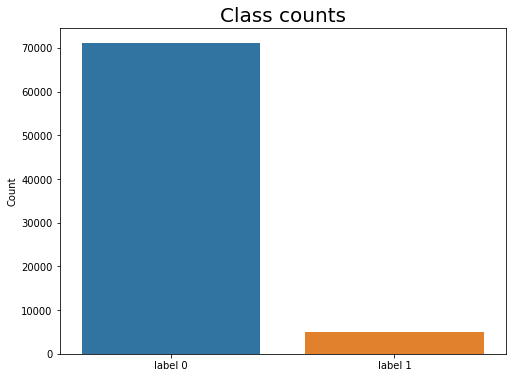

In [24]:
pos = train_xy[train_xy["label"] == 1].shape[0]
neg = train_xy[train_xy["label"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(train_xy["label"])
plt.xticks((0, 1), ["label 0", "label 1"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

significant class imbalance is present


In [25]:
# Checking number of unique values in numeric columns  
num_cols = train_xy.columns.tolist()
nunique_table(train_xy, which=num_cols, ascending=False)

column  unique values  % of total
0                ID          76097  100.000000
6            Score1          74252   97.575463
8            Score3          74243   97.563636
2            Income          74224   97.538668
9            Score4          74204   97.512386
10           Score5          74200   97.507129
7            Score2          74154   97.446680
1           Expense          74145   97.434853
4   Occupation type              3    0.003942
3         Loan type              2    0.002628
5               Age              2    0.002628
11            label              2    0.002628

occupation, loan type, age and label are categorical as already known

rest have enough unique values to be considered as continous 

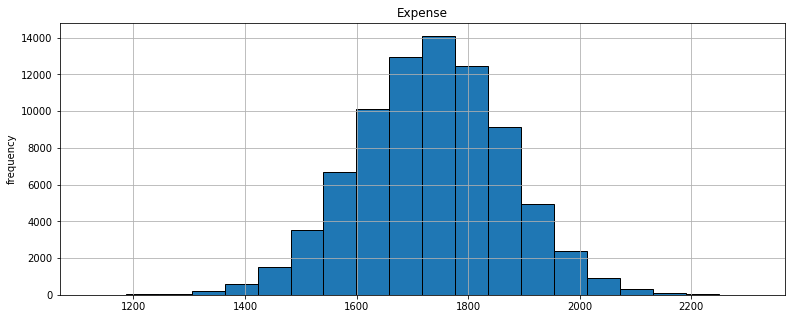

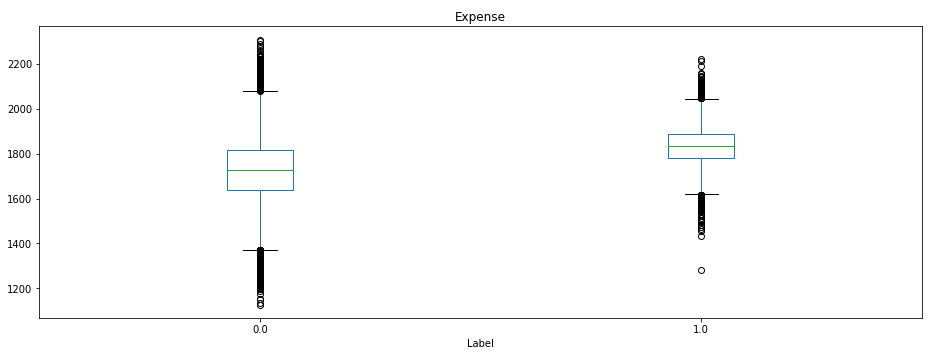

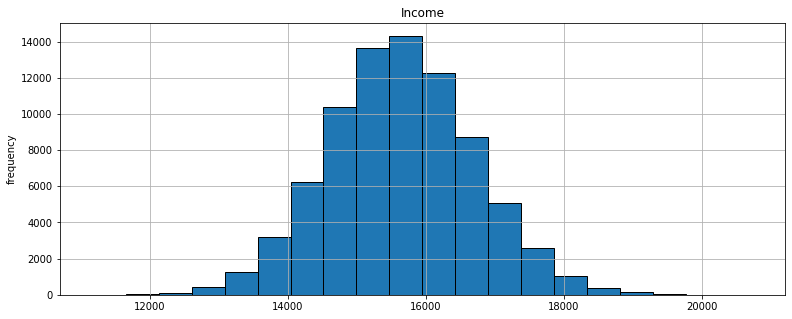

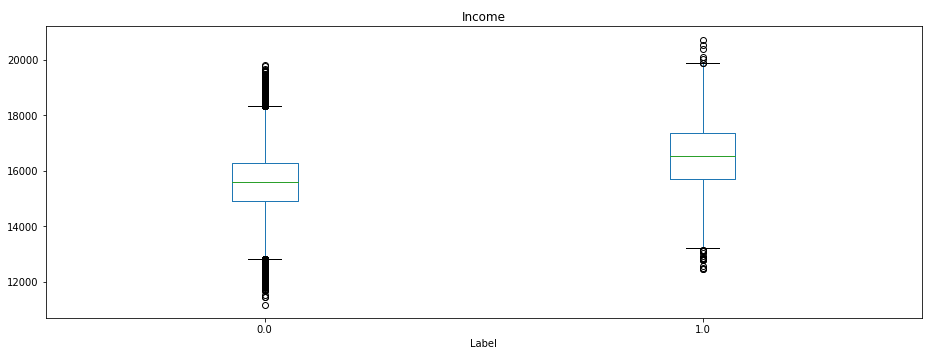

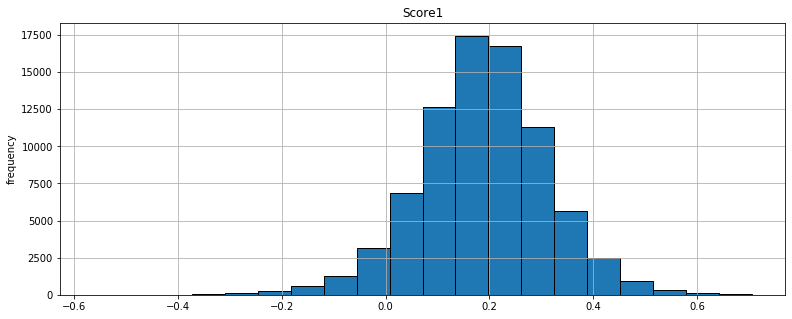

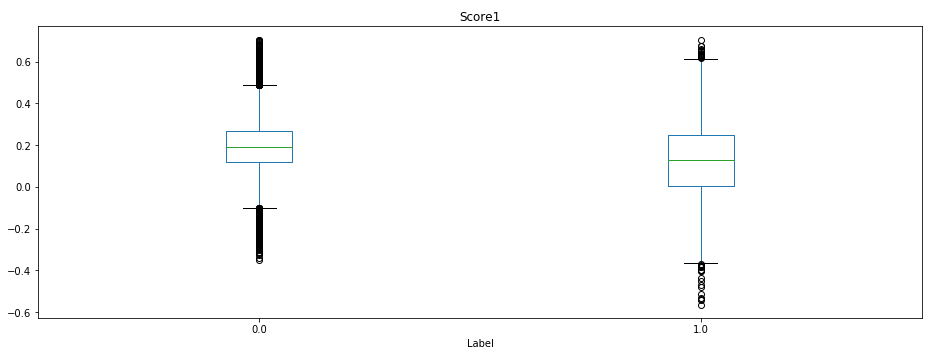

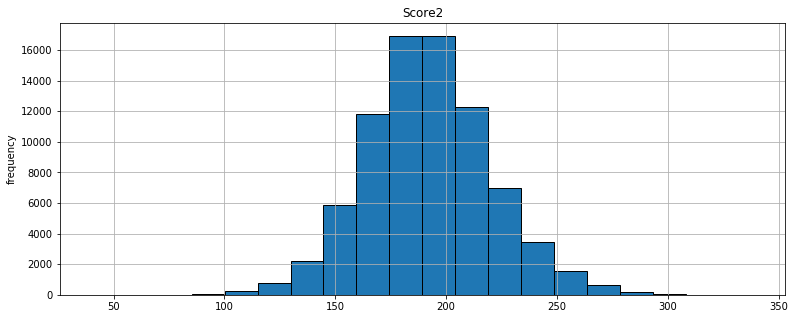

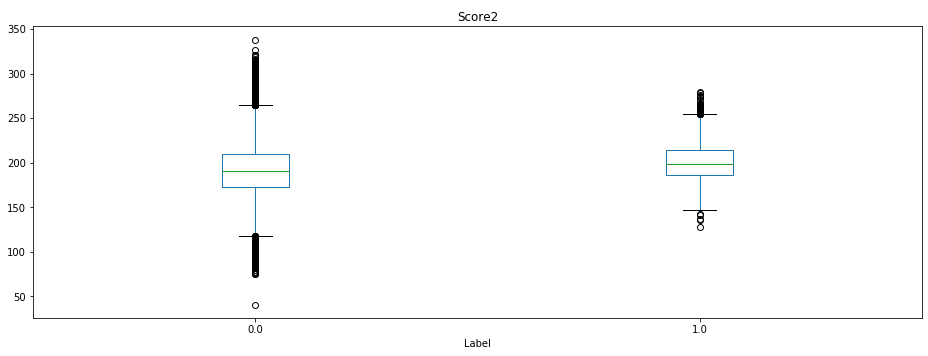

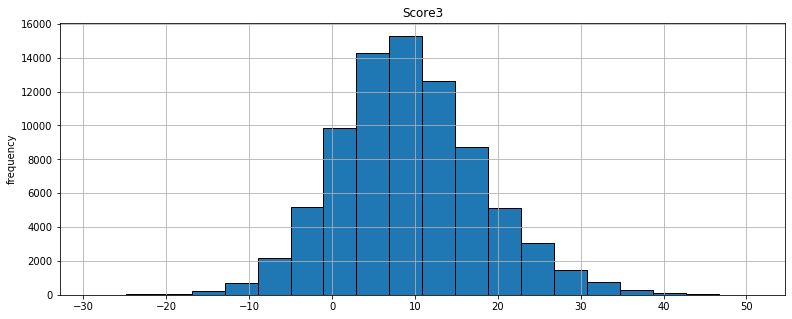

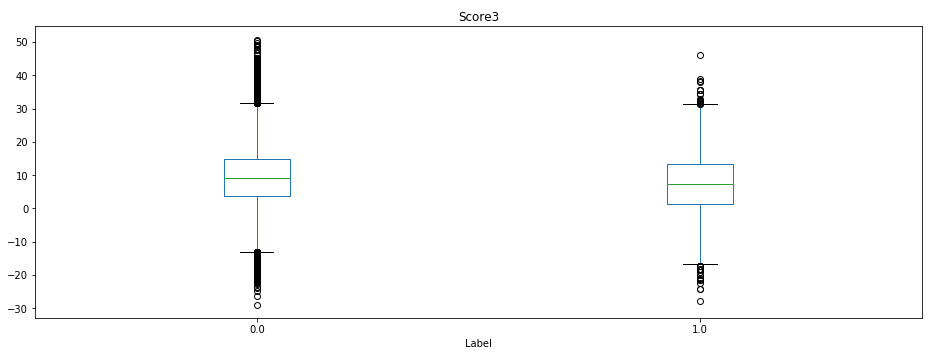

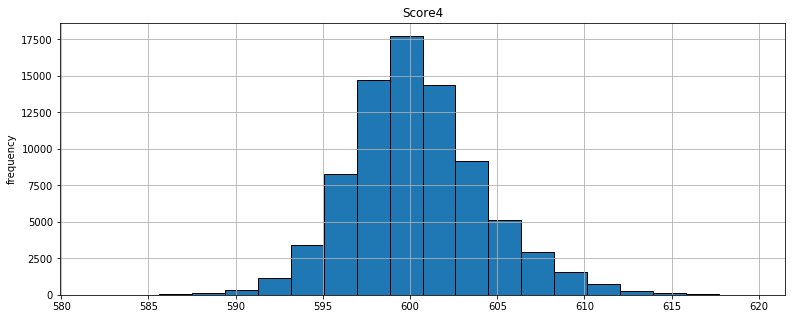

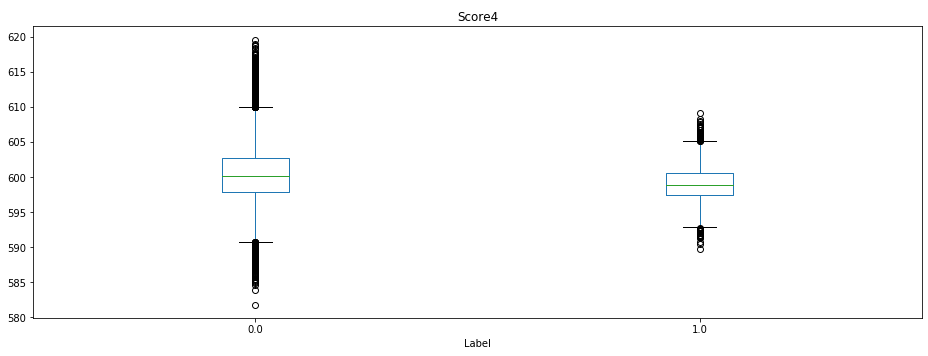

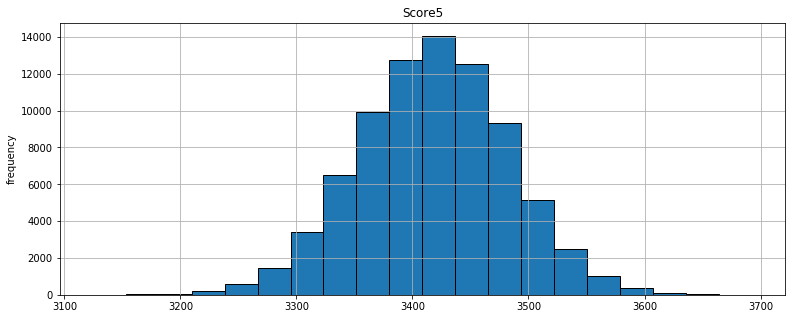

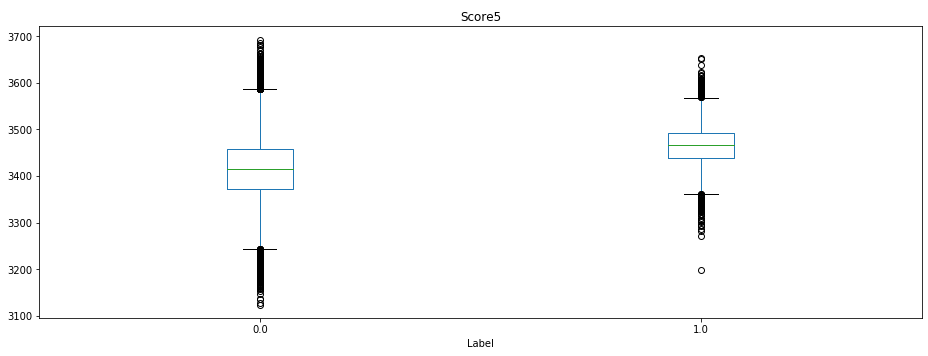

In [37]:
# Plotting distribution and probplot for each feature

num_cols = train_impt.columns.tolist()
num_col = num_cols.copy()
num_col.remove('ID')
num_col.remove('Label')
num_col.remove('Age')
num_col.remove('Occupation type')
num_col.remove('Loan type')
num_col
for col in train_impt.columns:
    train_impt[col] = train_impt[col].astype('float')

dist_dashboard(train_impt, num_cols=num_col)

from the histogram plot we can see that all the continuous features are normally distributed and are not scewed with respect to mean value.

In the box plot we can see many point lying outside the cutoff hence we will not consider than as ouliers except for the ones farthest among them.

eg.in the score 5 box plot score5= 3200 and Label=1 is an oulier. we can remove that

Label        0.0   1.0
Loan type             
0.0        40669  1835
1.0        34083  3413


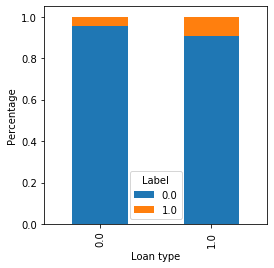

Label              0.0   1.0
Occupation type             
0.0              16961   491
1.0              35167  2549
2.0              22624  2208


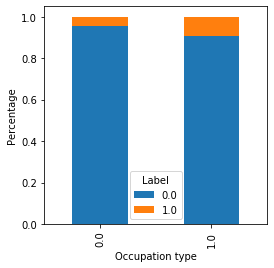

Label    0.0   1.0
Age               
0.0    42476  2203
1.0    32276  3045


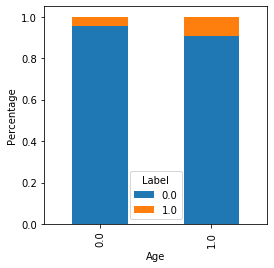

In [38]:
num_cols = train_impt_dscrt.columns.tolist()
percentage(train_impt_dscrt, num_cols)

loan type 1 has more proportion for label 1

Proportion of occupation type 2 is higher for the label 1

we can consider age,occupation type and loan type for model training

# Correlation map

Here, we will see correlation between features so that redundant features can be avoided.This will help solve multicollinearity and overfitting issues to an extent. We have shown correlations through a correlation heatmap.

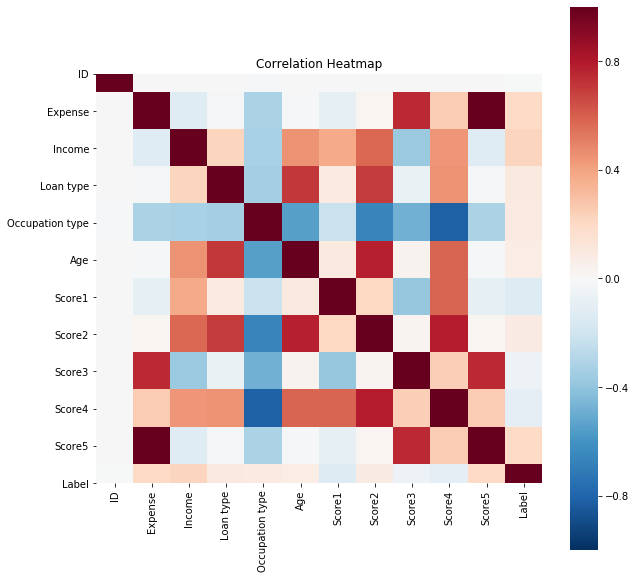

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(train_impt.corr(), square=True, annot=False, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
plt.title('Correlation Heatmap')
plt.show()

# Scatter Plots

Here we will use scatter plot to see which features are correlated


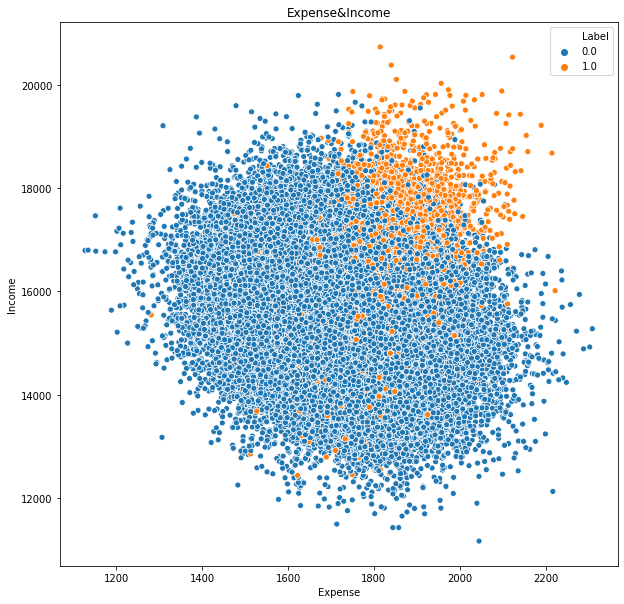

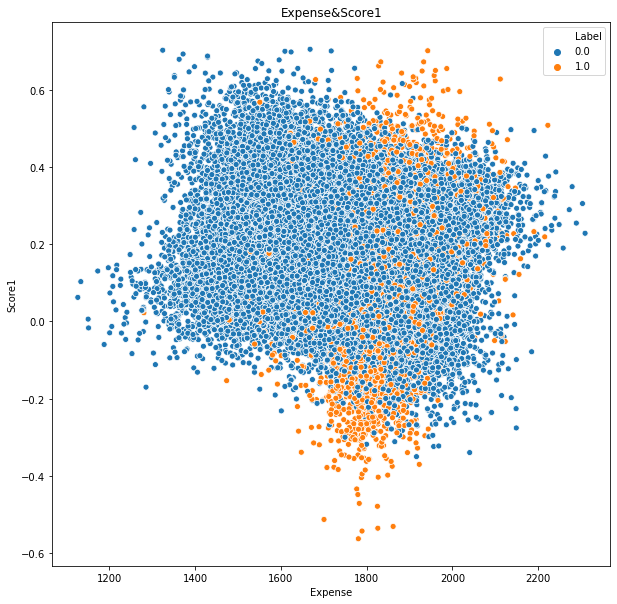

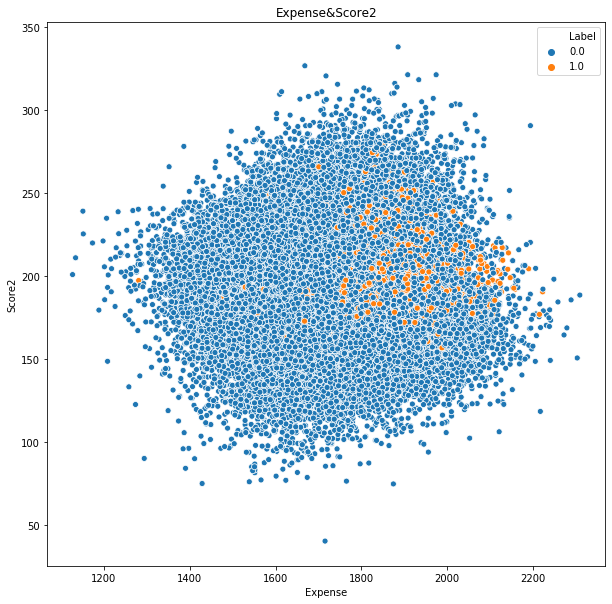

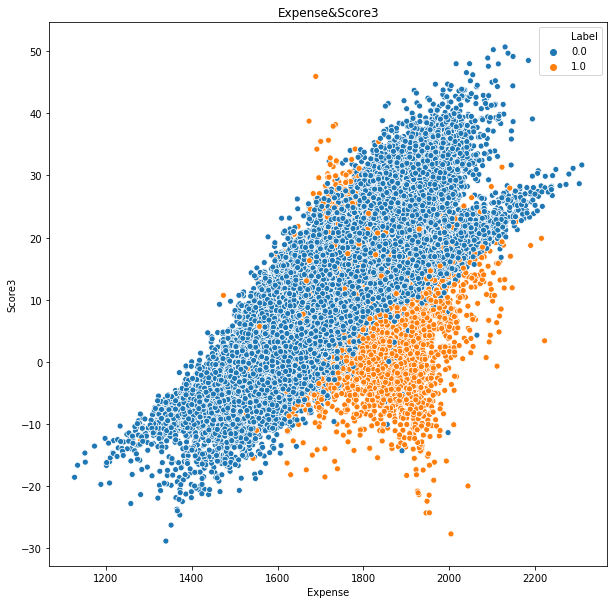

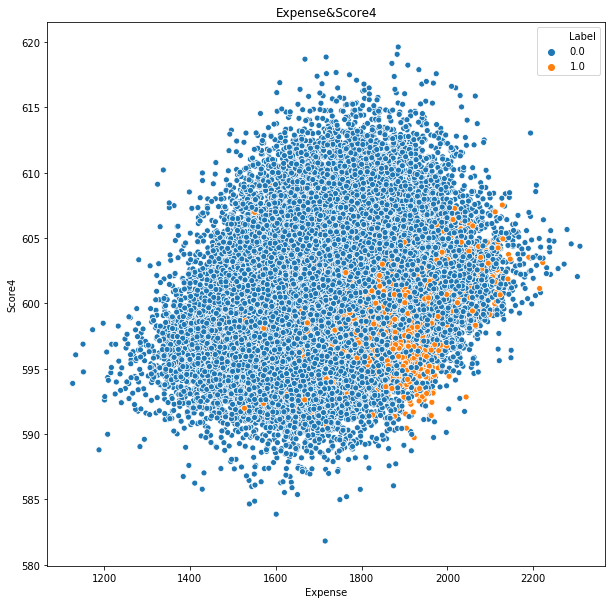

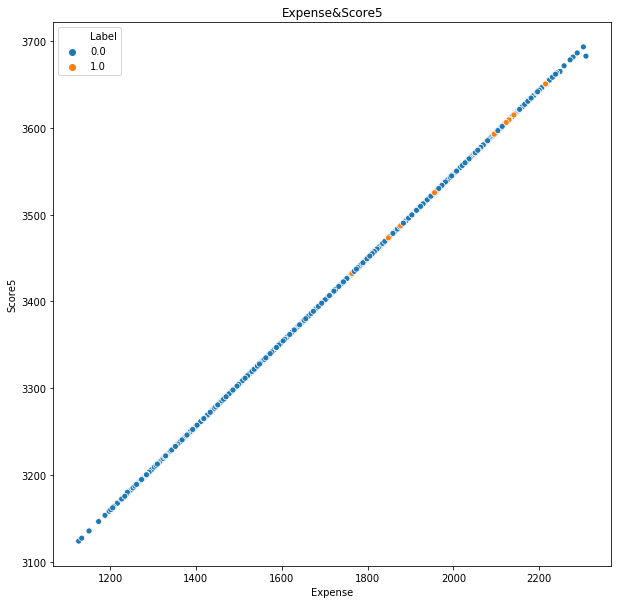

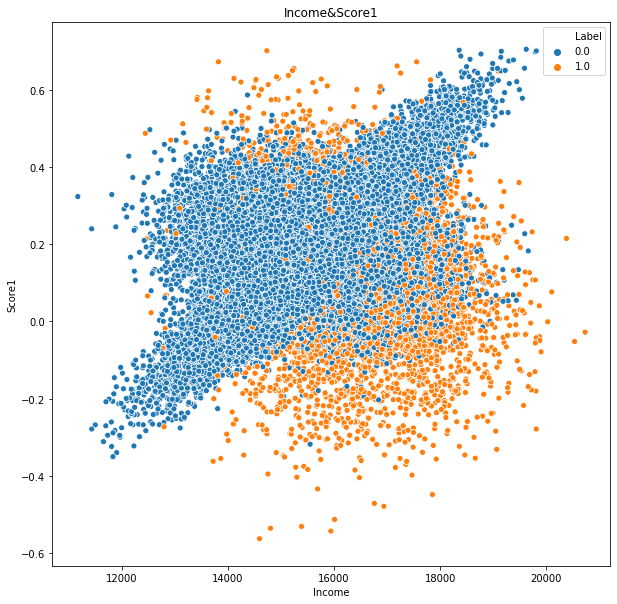

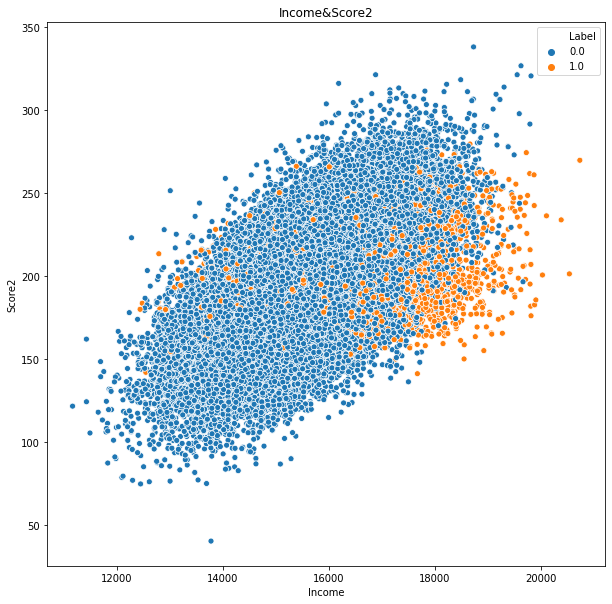

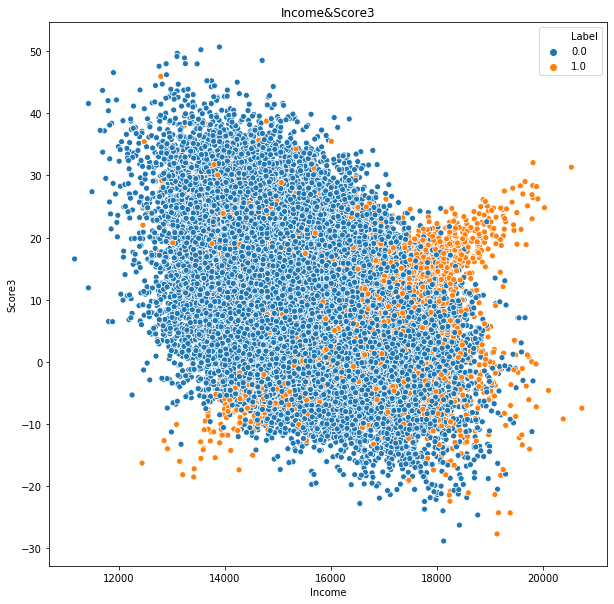

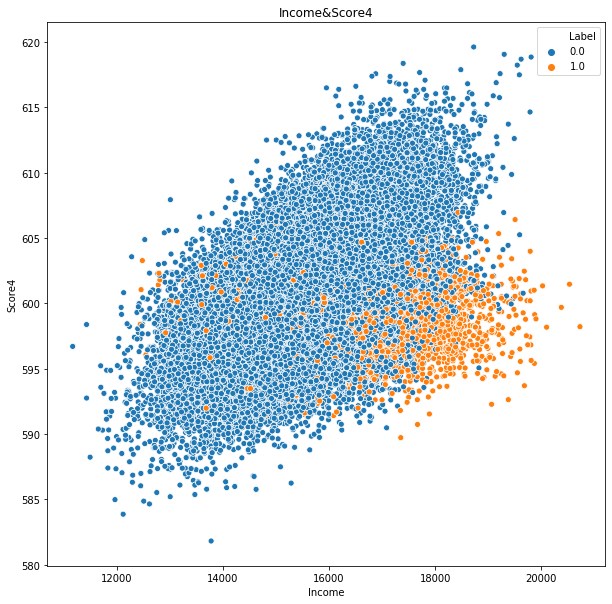

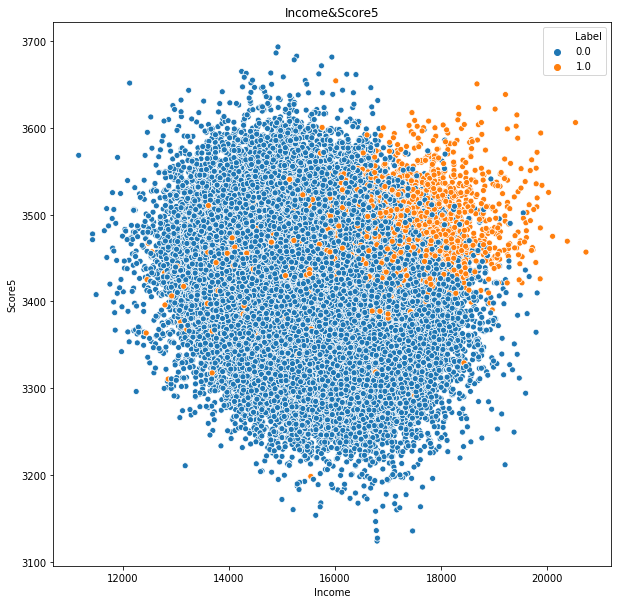

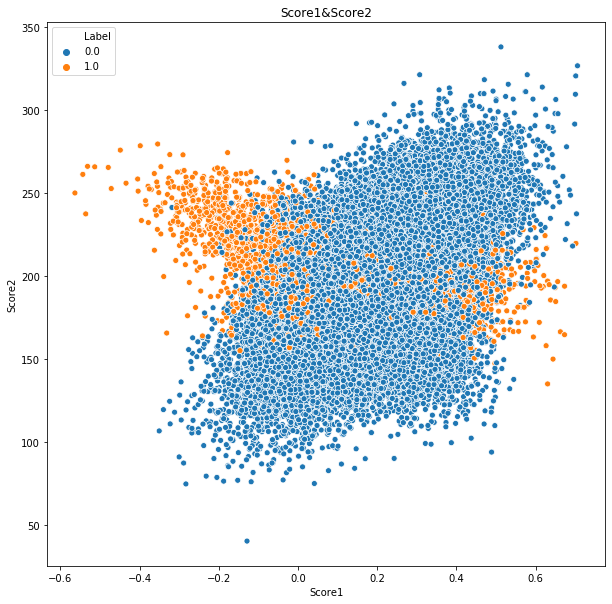

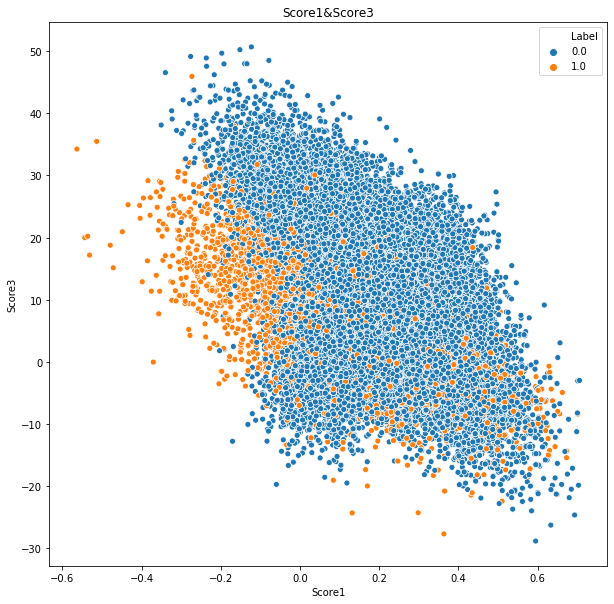

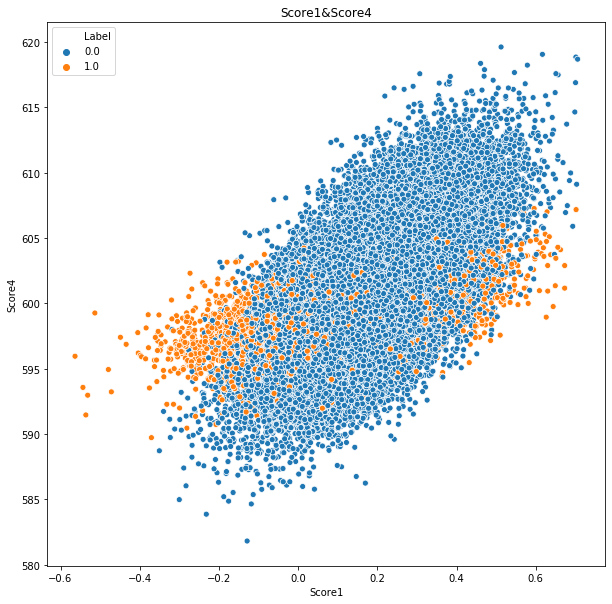

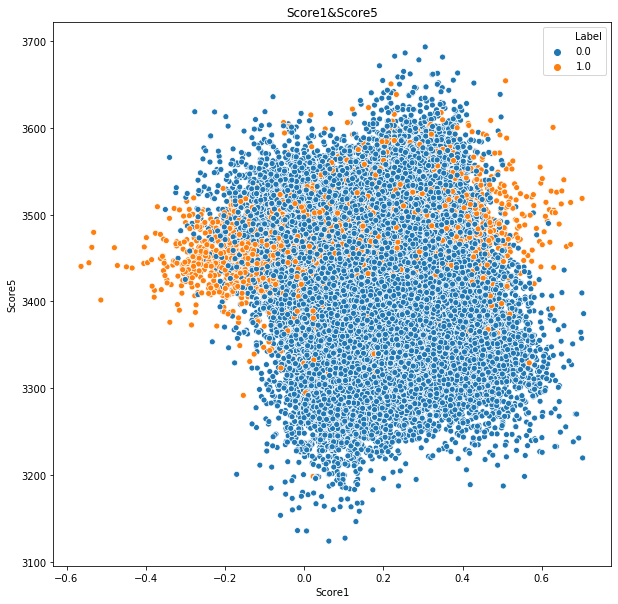

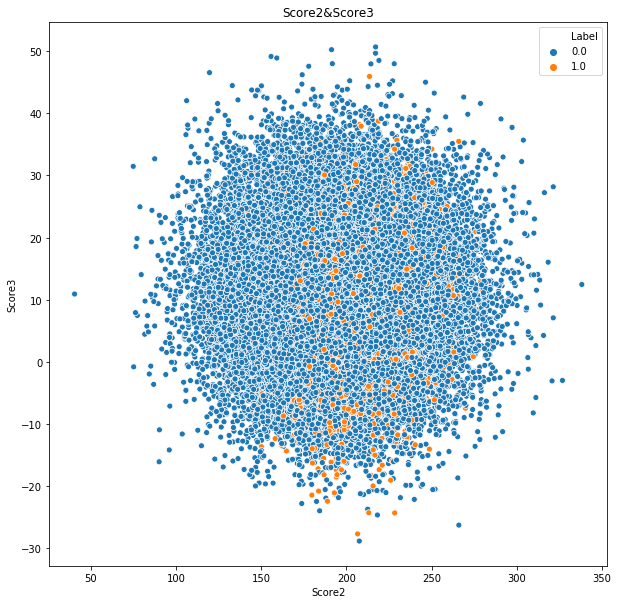

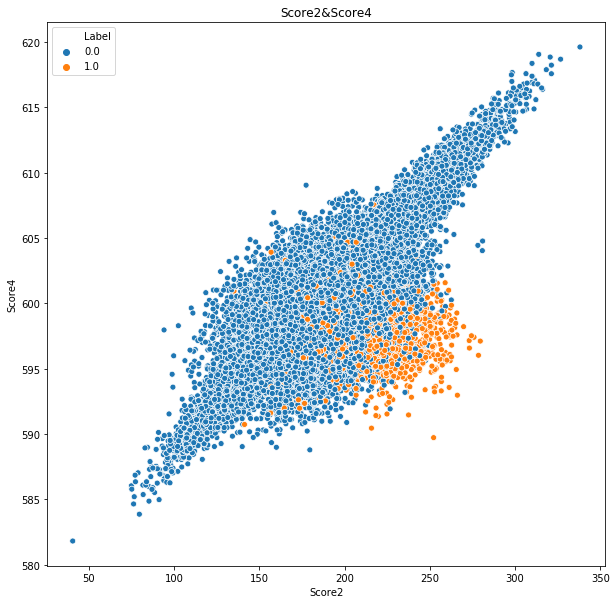

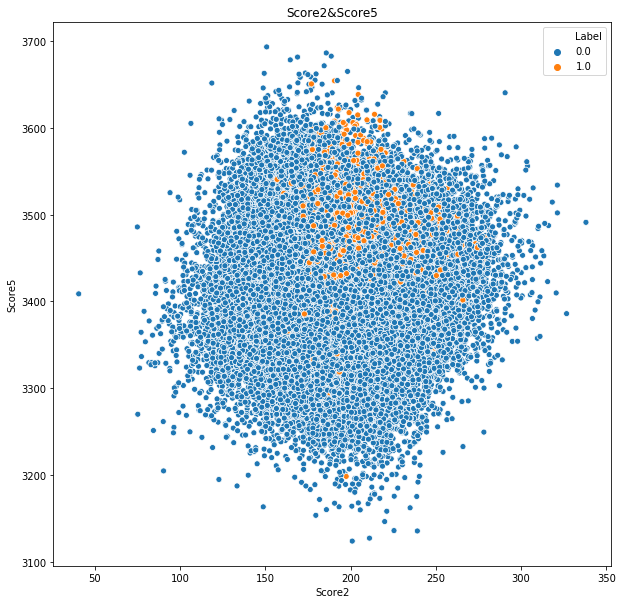

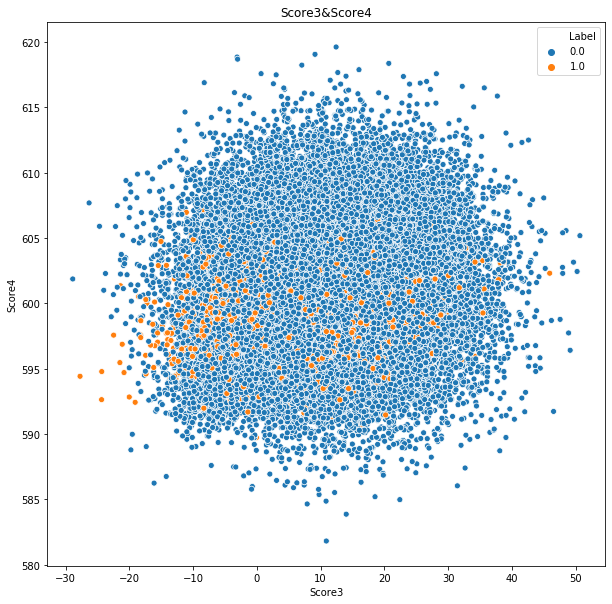

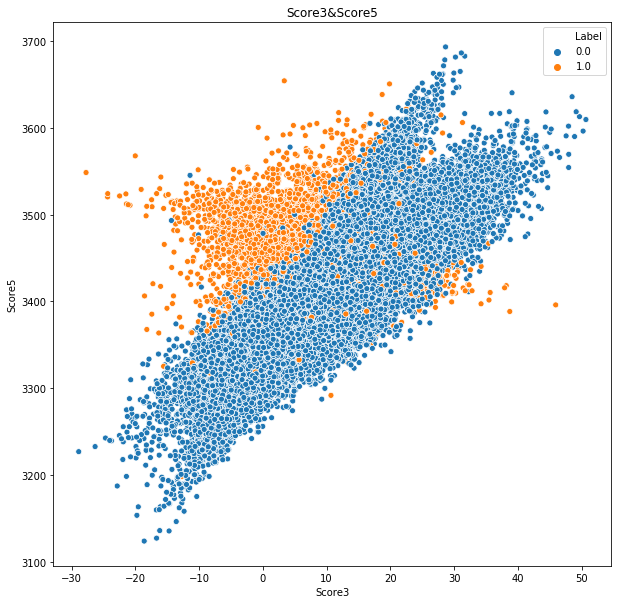

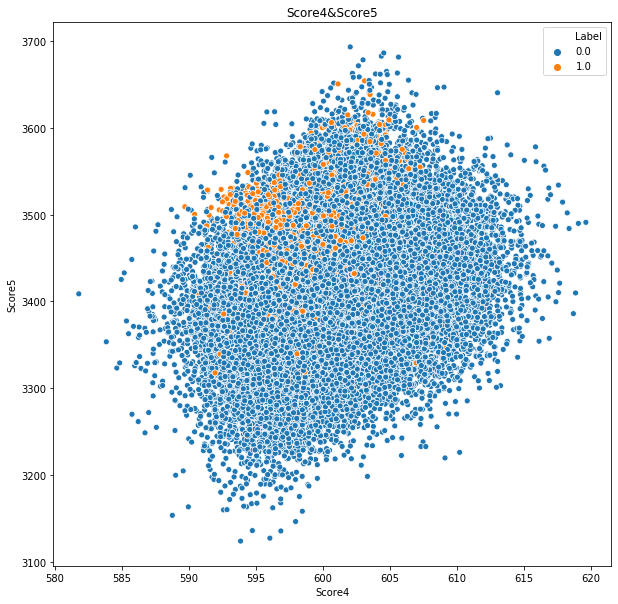

In [40]:
num_cols = train_impt_conts.columns.tolist()
scatter(train_impt, train_impt_conts, num_cols)

In [41]:
#from the plot we can see correlation between score5 and expense ,hence we can drop score 5

# Feature Impotance

Here we will fit a LightGBM model on the dataset and analyze feature importances of all features before and after imputation.

Original Data

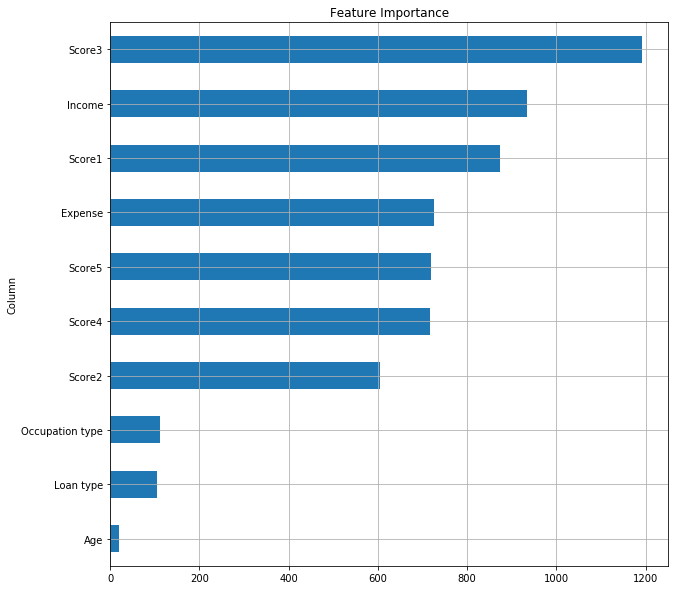

In [42]:
lgbm_importance(train_xy, 'ID', 'label', ascending=True)

Imputed data

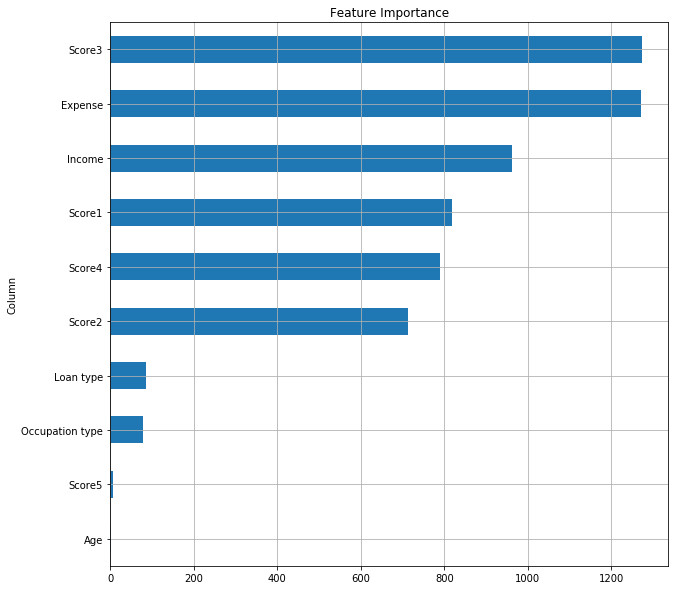

In [43]:
lgbm_importance(train_impt, 'ID', 'Label', ascending=True)